<h2>Importation des modules</h2>

In [1]:
# pour utiliser la base de données
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import sqlalchemy as db
import sqlite3

# pour effectuer des requêtes
import requests

# pour l'analyse et la visualisation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

#  pour faire un test statistique qui déterminers'il existe une association significative entre deux variables catégorielles
from scipy.stats import f_oneway, chi2_contingency

<h2>Connexion à la base de données</h2>

In [2]:
#  on crée un "moteur" qui va permettre de se connecter à la base de données
engine = create_engine('sqlite:///db.sqlite')

# on crée une connexion à la base de données qui pourra être utilisée pour exécuter des requêtes SQL.
connection = engine.connect()

<h2>1. Etude de la corrélation entre le nombre d'objets perdus et la température</h2>

<h3>1.1. Dataframes et diagramme de dispersion</h3>

In [3]:
request = """ 
    SELECT  Lost_Item.date, Lost_Item.code_uic,  Lost_Item.type_objet
    FROM Lost_Item 
"""

df_itemlost = pd.read_sql(request, connection, parse_dates=True)

df_itemlost['date'] = pd.to_datetime(df_itemlost['date'])
df_itemlost['date'] = df_itemlost['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_itemlost = df_itemlost.groupby(['date','code_uic']).agg('count').reset_index().rename(columns={'type_objet':"nombre_objets_perdus"})

df_itemlost

,date,code_uic,nombre_objets_perdus
0,2016-01-01,0087111849,3
1,2016-01-01,0087113001,1
2,2016-01-01,0087212027,7
3,2016-01-01,0087213058,1
4,2016-01-01,0087223263,1
...,...,...,...
109941,2021-12-31,0087756056,3
109942,2021-12-31,0087757625,1
109943,2021-12-31,0087761007,1
109944,2021-12-31,0087773002,6


In [4]:
request = """ 
    SELECT Gare.code_uic, Gare.code_departement
    FROM Gare
"""

df_gare = pd.read_sql(request, connection, parse_dates=True)
df_gare = df_gare.dropna(subset='code_departement').reset_index()

df_gare

,index,code_uic,code_departement
0,0,0087784868,66
1,1,0087784850,66
2,2,0087784843,66
3,3,0087784777,66
4,4,0087784769,66
...,...,...,...
3041,3185,0087113514,93
3042,3186,0087485060,17
3043,3187,0087700146,90
3044,3211,0087184408,90


In [5]:
df_merged = pd.merge(df_itemlost, df_gare, on='code_uic', how='left')

df_merged

,date,code_uic,nombre_objets_perdus,index,code_departement
0,2016-01-01,0087111849,3,2567,77
1,2016-01-01,0087113001,1,625,75
2,2016-01-01,0087212027,7,548,67
3,2016-01-01,0087213058,1,1161,67
4,2016-01-01,0087223263,1,1151,59
...,...,...,...,...,...
111786,2021-12-31,0087756056,3,45,06
111787,2021-12-31,0087757625,1,1971,06
111788,2021-12-31,0087761007,1,39,26
111789,2021-12-31,0087773002,6,2611,34


In [6]:
request = """ 
    SELECT *
    FROM Temperature
"""

df_temp = pd.read_sql(request, connection, parse_dates=True)
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp['date'] = df_temp['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_temp = df_temp.rename(columns={'departement_code':'code_departement'})

df_temp

,code_departement,date,temperature
0,05,2016-01-01,4.825
1,05,2016-01-02,3.575
2,05,2016-01-03,1.8625
3,05,2016-01-04,2.0
4,05,2016-01-05,3.2375
...,...,...,...
70139,87,2021-12-27,9.375
70140,87,2021-12-28,11.4
70141,87,2021-12-29,12.0375
70142,87,2021-12-30,11.475


In [7]:
df_final = pd.merge(df_merged, df_temp, on=['date', 'code_departement'], how='left')
df_final = df_final.dropna()

df_item_temp = pd.DataFrame(df_final[['nombre_objets_perdus','temperature']])
df_item_temp = df_item_temp.groupby('temperature').sum().reset_index()

df_sans_lignes_vides = df_item_temp[df_item_temp['temperature'] != '']
df_sans_lignes_vides['temperature'] = df_sans_lignes_vides['temperature'].astype(float)

df_sans_lignes_vides

/tmp/ipykernel_14451/1290225804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_lignes_vides['temperature'] = df_sans_lignes_vides['temperature'].astype(float)


,temperature,nombre_objets_perdus
0,-9.3500,8
1,-8.0750,1
2,-8.0000,4
3,-7.9625,6
4,-7.8000,8
...,...,...
10214,32.1875,11
10215,32.2750,5
10216,32.3500,6
10217,32.6125,4


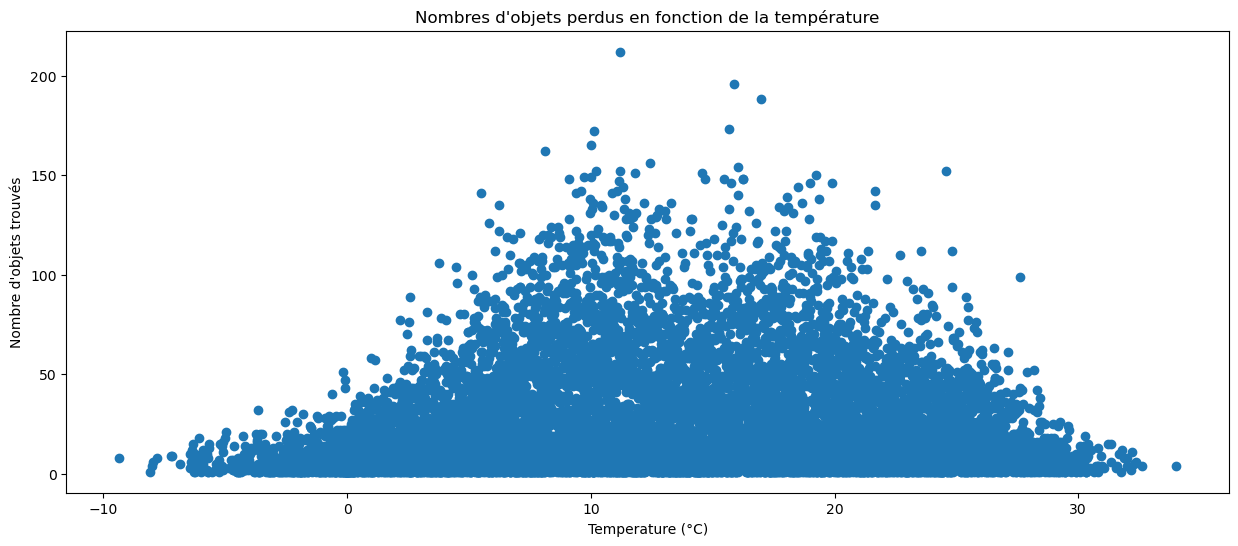

In [8]:
# on crée une figure 
plt.figure(figsize=(15,6))

# on crée un diagramme à dispersion avec les valeurs de la colonne "temperature" en abscisses et les valeurs de la colonne "nombre_objets_perdus" en ordonnées
plt.scatter(df_sans_lignes_vides['temperature'], df_sans_lignes_vides['nombre_objets_perdus'])

# Ajout du titre
plt.title("Nombres d'objets perdus en fonction de la température")

# on nomme les axes
plt.xlabel('Temperature (°C)')
plt.ylabel("Nombre d'objets trouvés")

# affichage
plt.show()



<h3>1.2. Corrélation entre la température et le nombre d'objets perdus</h3>

In [9]:
# Calculer le coefficient de corrélation de Pearson entre les colonnes "temperature" et "nombre_objets_perdus"
corr = df_sans_lignes_vides['temperature'].corr(df_sans_lignes_vides['nombre_objets_perdus'])

# Afficher le coefficient de corrélation
corr

0.05078268007445882

Ce résultat indique qu' il y a une faible relation linéaire entre ces deux variables.

<h2>2. Médiane du nombre d’objets perdus en fonction de la saison et diagramme en boîte</h2>

<h3>2.1. Médiane du nombre d’objets perdus en fonction</h3>

In [10]:
def obtenir_saison_par_mois(mois):
    if mois in [1, 2, 3]:
        return "Hiver"
    elif mois in [4, 5, 6]:
        return "Printemps"
    elif mois in [7, 8, 9]:
        return "Eté"
    elif mois in [10, 11, 12]:
        return "Automne"

In [11]:
# on récupère le dataframe df_itemlost en gardant seulement les colonnes "date" et "nombres d'objets perdus"
df_recup  = pd.DataFrame(df_itemlost[['date','nombre_objets_perdus']])

# on regroupe par date et on fait la somme des valeurs de la colonne "nommbre_objets_perdus" enregistrées à la même date
df_recup = df_recup.groupby('date').sum().reset_index()

# on change le type de la colonne "date" en datetime pour en extraire ensuite le mois
df_recup['date'] = pd.to_datetime(df_recup['date']).dt.month

# on applique maintenant la fonction "obtenir_saison_par_mois"
df_recup['date'] = df_recup['date'].apply(lambda mois : obtenir_saison_par_mois(mois))
df_recup = df_recup.rename(columns={'date':'saison'})

df_recup

,saison,nombre_objets_perdus
0,Hiver,83
1,Hiver,114
2,Hiver,134
3,Hiver,423
4,Hiver,250
...,...,...
2168,Automne,251
2169,Automne,211
2170,Automne,179
2171,Automne,218


In [12]:
for saison in df_recup['saison'].unique():

    mediane = df_recup[df_recup['saison'] == saison]['nombre_objets_perdus'].median()
    print(f"Pour la saison {saison}, la médiane de la série des nombres d'objets perdus vaut \x1b[34m{mediane}\x1b[0m")

Pour la saison Hiver, la médiane de la série des nombres d'objets perdus vaut 232.0
Pour la saison Printemps, la médiane de la série des nombres d'objets perdus vaut 198.5
Pour la saison Eté, la médiane de la série des nombres d'objets perdus vaut 250.5
Pour la saison Automne, la médiane de la série des nombres d'objets perdus vaut 222.5


<h3>2.2. Diagramme en boîte (Boxplot)</h3>

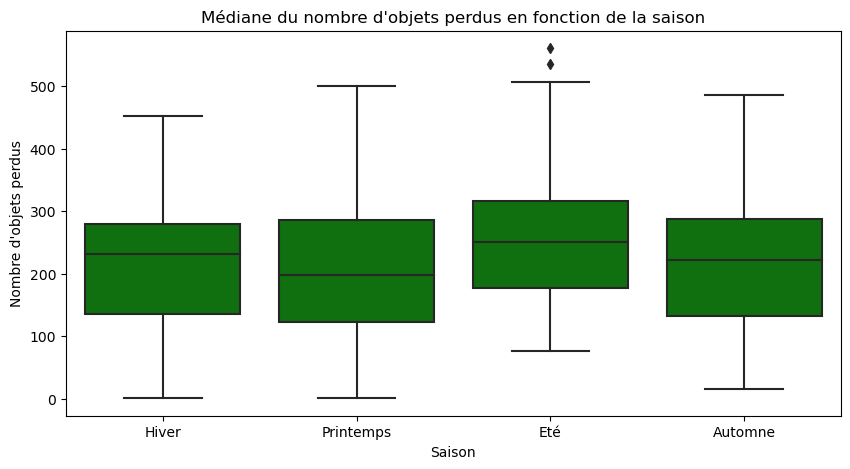

In [20]:
# on crée une figure
plt.figure(figsize=(10,5))

# Affichage des boxplots horizontalement
sns.boxplot(x ='saison', y ='nombre_objets_perdus', data = df_recup, color ='green')

# Ajout du titre
plt.title("Médiane du nombre d'objets perdus en fonction de la saison")

# Noms drs axes
plt.xlabel("Saison")
plt.ylabel("Nombre d'objets perdus")

# Affichage
plt.show()

<p>On remarque que les boxplots se ressemblent avec toutefois de légères différences au niveau de la médiane et de la répartition des valeurs.<br>
Ainsi, il ne semble pas y avoir de corrélation entre la saison et le nombre d'objets perdus.<br>
Mais on ne peut encore conclure à ce stade.</p>

<h3>2.3. Test de Fisher et p-valeur</h3>

Analyse de variance à un facteur (ANOVA à un facteur)

In [14]:
f_statistic, p_value = f_oneway(df_recup[df_recup['saison']=="Hiver"]["nombre_objets_perdus"], df_recup[df_recup['saison']=="Printemps"]["nombre_objets_perdus"], df_recup[df_recup['saison']=="Eté"]["nombre_objets_perdus"],df_recup[df_recup['saison']=="Automne"]["nombre_objets_perdus"])

In [15]:
print(f"F-statistic: {f_statistic:.3f}, p-value: {p_value:.6f}")

F-statistic: 26.419, p-value: 0.000000


<h2>3. Etude de la corrélation entre le nombre d'objets perdus et le mois</h2>

<h3>3.1. Dataframes</h3>

In [16]:
# on sélectionne les colonnes date et type d'objest perdus
request = """ 
    SELECT Lost_Item.date, Lost_Item.type_objet
    FROM Lost_Item 
"""

#  on lit et importe les données depuis la base de données en utilisant la requête SQL spécifiée et on convertit les colonnes de type date en objets de type "datetime"
df_itemlost = pd.read_sql(request, connection, parse_dates=True)

# on rajoute cette ligne pour être sûr d'avoir une colonne date avec des valeurs de type datetime
df_itemlost['date'] = pd.to_datetime(df_itemlost['date'])

# on affiche le dataframe avec des dates en format yyyy-mm-dd 
df_itemlost['date'] = df_itemlost['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_itemlost = df_itemlost.groupby('date').count().reset_index().rename(columns={"type_objet":"nombre_objets_perdus"})

df_itemlost['date'] = pd.to_datetime(df_itemlost['date']).dt.month
df_itemlost

,date,nombre_objets_perdus
0,1,83
1,1,114
2,1,134
3,1,423
4,1,250
...,...,...
2168,12,251
2169,12,211
2170,12,179
2171,12,218


In [17]:
def obtenir_mois(numero_mois):
  # Définir une liste des noms de mois
  mois = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']

  # Renvoyer le nom du mois correspondant
  return mois[numero_mois-1]

In [18]:
df_itemlost['date'] = df_itemlost['date'].apply(lambda numero_mois : obtenir_mois(numero_mois))
df_itemlost = df_itemlost.rename(columns={'date':'mois'})
df_itemlost

,mois,nombre_objets_perdus
0,janvier,83
1,janvier,114
2,janvier,134
3,janvier,423
4,janvier,250
...,...,...
2168,décembre,251
2169,décembre,211
2170,décembre,179
2171,décembre,218


<h3>3.2. Diagramme en boîte (Boxplot)</h3>

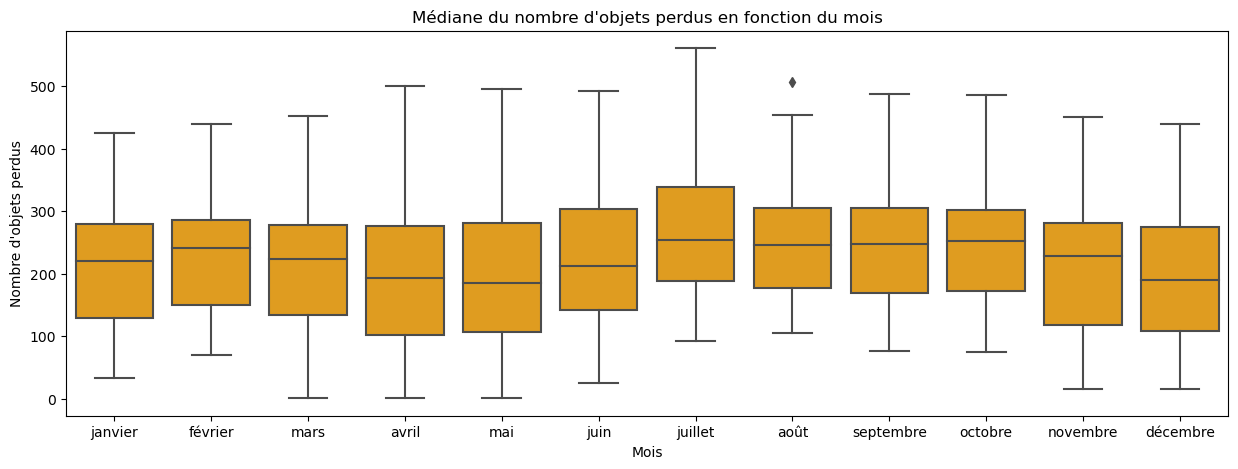

In [22]:
# on crée une figure
plt.figure(figsize=(15,5))

# Affichage des boxplots horizontalement
sns.boxplot(x ='mois', y ='nombre_objets_perdus', data = df_itemlost, color ='orange')

# Ajout du titre
plt.title("Médiane du nombre d'objets perdus en fonction du mois")

# Noms drs axes
plt.xlabel("Mois")
plt.ylabel("Nombre d'objets perdus")

# Affichage
plt.show()

<p>On remarque que les boxplots se ressemblent avec toutefois de légères différences au niveau de la médiane et de la répartition des valeurs.<br>
Ainsi, il ne semble pas y avoir de corrélation entre le mois et le nombre d'objets perdus.<br>
Mais on ne peut encore conclure à ce stade.</p>

<h3>3.3. Test du chi-2 de contingence</h3>

In [53]:
request = """ 
    SELECT  Lost_Item.date,  Lost_Item.type_objet, Lost_Item.code_uic
    FROM Lost_Item 
"""

df_itemlost = pd.read_sql(request, connection, parse_dates=True)

df_itemlost['date'] = pd.to_datetime(df_itemlost['date'])

df_itemlost = df_itemlost.groupby([pd.Grouper(key='date', freq='M'),'type_objet']).count().reset_index().rename(columns={'code_uic':'nombre_objets_perdus_par_type'})

df_itemlost['date'] = df_itemlost['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_itemlost['date'] = pd.to_datetime(df_itemlost['date']).dt.month
df_itemlost = df_itemlost.rename(columns={'date':'mois'})

df_itemlost

,mois,type_objet,nombre_objets_perdus_par_type
0,1,"Appareils électroniques, informatiques, appare...",1033
1,1,"Articles d'enfants, de puériculture",79
2,1,"Articles de sport, loisirs, camping",63
3,1,Articles médicaux,49
4,1,"Bagagerie: sacs, valises, cartables",2112
...,...,...,...
1140,12,Parapluies,63
1141,12,Pièces d'identités et papiers personnels,374
1142,12,"Porte-monnaie / portefeuille, argent, titres",721
1143,12,"Vélos, trottinettes, accessoires 2 roues",102


In [57]:
contingency_table = pd.crosstab(df_itemlost['type_objet'], df_itemlost['mois'], values = df_itemlost['nombre_objets_perdus_par_type'], aggfunc = 'sum')
contingency_table

mois,1,2,3,4,5,6,7,8,9,10,11,12
type_objet,,,,,,,,,,,,
"Appareils électroniques, informatiques, appareils photo",5879,5962,5905,4915,5322,6199,7118,6379,6487,6717,5553,5416
"Articles d'enfants, de puériculture",381,438,377,379,378,352,649,730,368,429,338,394
"Articles de sport, loisirs, camping",335,380,348,295,353,455,1029,1119,529,385,310,257
Articles médicaux,206,187,188,180,213,220,256,280,231,221,213,192
"Bagagerie: sacs, valises, cartables",13103,12896,12282,10054,10346,10964,14508,13770,12674,14457,12883,13211
"Bijoux, montres",379,412,337,280,328,357,485,418,394,420,334,361
"Clés, porte-clés, badge magnétique",1924,1789,1806,1486,1725,1851,2022,1743,2033,1977,1686,1504
Divers,760,689,710,613,659,787,1069,1068,875,942,743,756
Instruments de musique,92,79,101,96,99,84,166,159,114,102,93,106


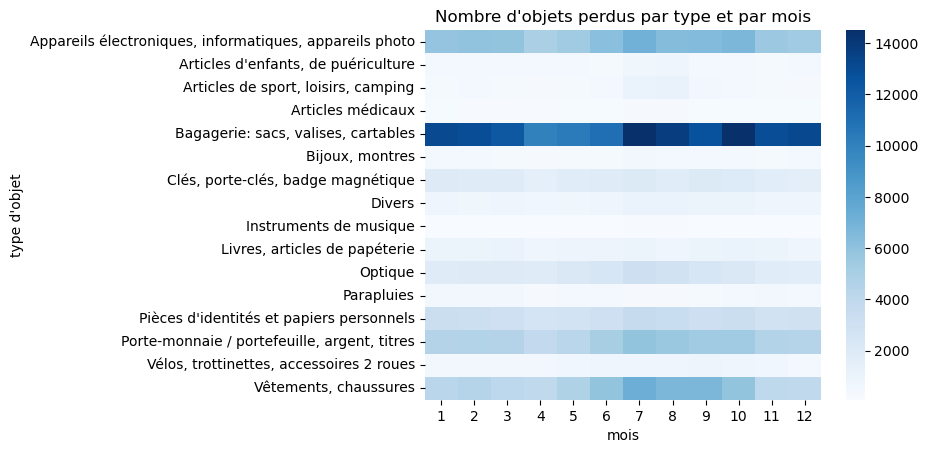

In [61]:
# Création du heatmap
sns.heatmap(contingency_table, cmap='Blues')

plt.title("Nombre d'objets perdus par type et par mois")

plt.xlabel("mois")
plt.ylabel("type d'objet")

# Affichage du heatmap
plt.show()

In [62]:
# on calcule le test du khi-deux pour une table de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [67]:
print("Statistique du test du khi-deux : ", round(chi2, 3))
print("P-value du test du khi-deux : ", round(p, 3))
print("Degrés de liberté : ", dof)

Statistique du test du khi-deux :  4837.469
P-value du test du khi-deux :  0.0
Degrés de liberté :  165
